# DAMP Dataset Pre-processing

This notebook provides the functions to convert raw audio and lyrics into tfrecords. 
The main structure of the code are similar to DALI dataset pre-processing with some changes. 
This code is made possible by code reference from Jens Johannsmeier on Gitlab and also Oleksii Bashkanov DALI data preparation code.

The dataset is already split into training and testing, therefore the input will need to specifiy which dataset to input (training/testing).

- Paper: ["Semi-supervised Lyrics and Solo-singing Alignment"](http://ismir2018.ircam.fr/doc/pdfs/30_Paper.pdf) by Gupta et al. 
- Dataset provided on googledrive: https://drive.google.com/drive/folders/1hGuE0Drv3tbN-YNRDzJJMHfzKH6e4O2A

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import librosa
%matplotlib inline  
import matplotlib.pyplot as plt
import librosa.display
import pickle 
import re #regular expression
import tensorflow as tf
from functools import reduce

# Methods for processing audio

In [3]:
def raw_to_mel(audio, sampling_rate, window_size, hop_length, n_freqs):
    """Go from 1D numpy array containing audio waves to mel spectrogram.

    Parameters:
        audio: 1D numpy array containing the audio.
        sampling_rate: Sampling rate of audio.
        window_size: STFT window size.
        hop_length: Distance between successive STFT windows.
        n_freqs: Number of mel frequency bins.

    Returns:
        Processed spectrogram, bins x time.

    """    
    spectro = librosa.stft(audio, n_fft=window_size, hop_length=hop_length,
                           center=True)
    power = np.abs(spectro)**2
    mel = librosa.feature.melspectrogram(S=power, sr=sampling_rate,
                                         n_mels=n_freqs)
    logmel = np.log(mel + 1e-11)
    return logmel

def raw_to_pcen(audio, sampling_rate, window_size, hop_length, n_freqs):
    """Go from 1D numpy array containing audio waves to PCEN spectrogram.

    Parameters might not be optimal...

    Parameters:
        audio: 1D numpy array containing the audio.
        sampling_rate: Sampling rate of audio.
        window_size: STFT window size.
        hop_length: Distance between successive STFT windows.
        n_freqs: Number of mel frequency bins.

    Returns:
        PCEN spectrogram, bins x time.

    """
    spectro = np.abs(librosa.stft(audio, n_fft=window_size,
                                  hop_length=hop_length, center=True))
    mel = librosa.feature.melspectrogram(S=spectro, sr=sampling_rate,
                                         n_mels=n_freqs)
    pcen = librosa.pcen(mel, sr=sampling_rate, hop_length=hop_length,
                        time_constant=0.285)
    return pcen

def chs_to_inds(char_list, mapping):
    """Helper to convert a list of characters to a list of corresponding indices.

    Parameters:
        char_list: List of characters (or string).
        mapping: Dict mapping characters to indices.

    Returns:
        List of character indices.
    """
    return [mapping[ch] for ch in char_list]

In [4]:
def trim_audio(audio, sr, start, end):
    """start, end - in seconds (float)
    Return:
        Trimmed audio, None if out of boudaries
    """
    assert start < end, "End time step should be bigger then start time step."
    audio_segment = audio[round(start*sr): round(end*sr)]
    return audio_segment

def mel_plot(S):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), #convert power to db
                             y_axis='log',x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    return plt.show()

def audio_stack(audio_dir, audio_path, trim = True):
    '''
    If trim is True, silent region 2s before and after the audio will be removed
    
    Returns: 
        List of audio
        Sampling rate
        List of audio duration
    '''
    audio_list = [] #audio time-series
    t_list = [] #time duration 
    for audio in audio_dir:
        path = os.path.join(audio_path, audio)
        y, sr = librosa.load(path)
        if trim == True:
            y = trim_audio(y, sr, 2, audio_length-2)
        audio_list.append(y)
        t_list.append(librosa.get_duration(y=y, sr=sr))
    
    print('Sample rate: {} Hz'.format(sr)) #sample rate is same for all audio    
    return audio_list, sr, t_list

# Melspectogram plot for one example

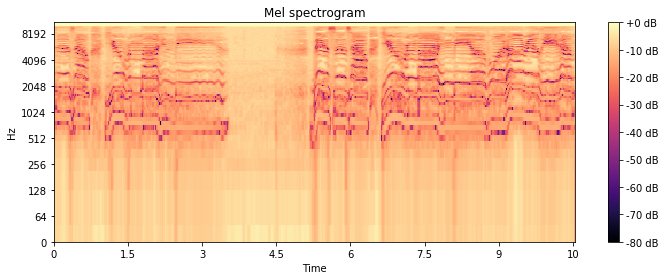

Size of mel-spectogram:  (128, 454)
Sample rate: 22050


In [5]:
test_audio_file = 'DAMP_test'

file_loc = os.path.join(test_audio_file,'70957290_37707910_how_you_remind_me_02_Machine1_0.wav')
audio, sr = librosa.load(file_loc)
audio_length = librosa.get_duration(y=audio, sr=sr)
audio_segment = trim_audio(audio, sr, 2, audio_length-2)
logmel = raw_to_mel(audio_segment, sr, window_size = 2048, hop_length = 512, n_freqs = 128)
mel_plot(logmel)

print("Size of mel-spectogram: ", logmel.shape)
print("Sample rate:", sr)

Specify test and training data directory

In [6]:
test_audio_file = 'DAMP_test'
train_audio_file = 'DAMP_train'

test_audio_dir = sorted(os.listdir(test_audio_file))
train_audio_dir = sorted(os.listdir(train_audio_file))

In [7]:
print('Number of audio for training: ',len(train_audio_dir))
print('Number of audio for testing: ',len(test_audio_dir))

Number of audio for training:  35662
Number of audio for testing:  1697


# Methods for processing text

In [8]:
def remove_header(read_txt, write_txt):
    '''
    Remove header from lyrics transcription.
    
    Parameters:
        read_txt: Lyrics transcription text file that contains header
        write_txt: New txt file with lyrics without header
    
    Return:
        A list of lyrics header to check alignment of audio segment
    '''
    f = open(read_txt, 'r')
    l = []
    k = []
    write_file = open(write_txt,'w')
    for x in f:
        l.append((x.split(' ',1)[0])) #headers before the true lyrics start
        k.append((x.split(' ',1)[1])) #lyrics transcription without headers
    #Example
#     print('Headers:',l[0])
#     print('Lyrics without headers:', k[0])
    
    for i in range(len(k)):    
        write_file.write(k[i])
    return l

def map_text2char(read_txt):
    '''
    Remove special characters/symbols and convert all characters into lower case
    Parameters:
        read_txt: Txt file to be input
    '''
    chars = set()
    with open(read_txt) as text:
        for line in text:
            line = re.sub('[^A-Za-z\']+', ' ', line).lower()
            chars.update(set(line))
        mapping = dict(zip(chars, range(3, len(chars)+3)))
        mapping["<PAD>"] = 0
        mapping["<S>"] = 1
        mapping["</S>"] = 2

    #save vocab
    with open('damp_vocab', 'wb') as fp:
        pickle.dump(mapping, fp)
        
    return mapping

def enumerate_lines(file):
    """
    Enumerate lines in lyrics transcript for iteration
    
    Parameter:
    file: test/train lyrics transcript
    """
    with open(file) as text:
        return [line for i, line in enumerate(text)]

## Iterate over whole dataset to create dictionary

Dictionary for training data

In [9]:
train_remove_header = remove_header('DAMP_train.txt','DAMP_train_lyrics.txt')
train_enum = enumerate_lines('DAMP_train_lyrics.txt')
train_mapping = map_text2char('DAMP_train_lyrics.txt')
print(train_mapping)

{'x': 3, 'u': 4, "'": 5, 'f': 6, 't': 7, 'd': 8, 'b': 9, 'h': 10, 'e': 11, 'a': 12, 'm': 13, 'i': 14, 'w': 15, 'z': 16, 'y': 17, 'o': 18, 'c': 19, 'g': 20, 'q': 21, 'k': 22, ' ': 23, 'p': 24, 'v': 25, 'r': 26, 's': 27, 'n': 28, 'l': 29, 'j': 30, '<PAD>': 0, '<S>': 1, '</S>': 2}


Dictionary for test data

In [10]:
test_remove_header = remove_header('DAMP_test.txt','DAMP_test_lyrics.txt')
test_enum = enumerate_lines('DAMP_test_lyrics.txt')
test_mapping = map_text2char('DAMP_test_lyrics.txt')
print(test_mapping)

{'x': 3, 'u': 4, "'": 5, 'f': 6, 't': 7, 'd': 8, 'b': 9, 'a': 10, 'e': 11, 'm': 12, 'h': 13, 'i': 14, 'w': 15, 'z': 16, 'y': 17, 'o': 18, 'c': 19, 'g': 20, 'q': 21, 'k': 22, ' ': 23, 'v': 24, 'p': 25, 'l': 26, 's': 27, 'r': 28, 'n': 29, 'j': 30, '<PAD>': 0, '<S>': 1, '</S>': 2}


Example

In [11]:
print(train_enum[0])
print(test_enum[0])

IT'S BIGGER IT'S BIGGER THAN YOU AND YOU ARE NOT ME 

MAKES YOU FEEL SO SMALL BUT I SEE YOUR TRUE COLORS SHINING THROUGH I SEE YOUR 



In [12]:
for i in range(10):
    for line in test_enum[i]:
        line = re.sub('[^A-Za-z0-9\']+', ' ', line).lower()
        mapped = [test_mapping["<S>"]] + chs_to_inds(line, test_mapping) + [test_mapping["</S>"]]
        print(line,end='')
    print('\n')

makes you feel so small but i see your true colors shining through i see your  

can't remember when i last saw you laughing if this world makes you crazy and you've taken  

stronger power i got that power i got that power  

y on my way to that valet used to have a piggy bank but now i got that bigger bank who who cares what the haters say they hate on me cuz we doing what they can't i stay on that hustle  

hustle i flex that mental muscle hate to burst your bubble i'm on that other level imma take it higher and high high and higher i stay and buy attire  

i'm loving every second minute hour bigger better stronger power i got that power  

i got that power i got that power power power power ye ye ye yes y'all feeling funky fresh y'all work to be the  

under pressure been through all that stress y'all get get this off my chest y'all made it out them projects with this project that's progress y'all i did it for my mama i told her when i was younger  

that imma be that number one yu

## Debugging Aligment of Lyrics Transcription with associated Audio Segments

Compare headers of audio segment w.r.t lyrics transcription to ensure that the sequence are matched.

In [13]:
def extension_remover(audio_dir):
    """
    Remove .wav extension from audio segments
    Parameter: 
        audio_dir:test_audio_dir/ train_audio_dir
    Return:
        List of audio header without .wav 
    """
    c = audio_dir
    l=[c[i].split('.wav')[0] for i in range(len(c))]
    return l

def comparison(audio_list, lyrics_list):
    """
    Compare headers of audio segment w.r.t lyrics transcription 
    to ensure that the sequence are matched.
    Parameter:
        audio_list: audio header list
        lyrics_list: lyrics header list
    """
    if len(audio_list)==len(lyrics_list):
        print('Length-aligned!')
        for i in range(len(audio_list)):
            if audio_list[i] != lyrics_list[i]:
                print('Index that is not aligned: ',i)

In [14]:
train_list_noheader = extension_remover(train_audio_dir)
test_list_noheader = extension_remover(test_audio_dir)

comparison(train_list_noheader, train_remove_header)
comparison(test_list_noheader, test_remove_header)

Length-aligned!
Length-aligned!


## Create .npy

In [15]:
def convert_to_numpy(audio_list, output_path,npy_name):
    audio_list=np.asarray(audio_list)
    outputfilepath=os.path.join(output_path,npy_name)
    np.save(outputfilepath +'.npy', audio_list)

In [16]:
output_path = os.getcwd()

In [17]:
audio_list_test, sr, _ = audio_stack(test_audio_dir, test_audio_file)
convert_to_numpy(audio_list_test, output_path, 'DAMP_test')

Sample rate: 22050 Hz


In [ ]:
audio_list_train, sr, _ = audio_stack(train_audio_dir, train_audio_file)
convert_to_numpy(audio_list_train, output_path, 'DAMP_train')

# Tfrecords creation

In [ ]:
def create_tfrecords(out_filename, enum_list, audio_list, func=raw_to_mel, path_to_save=''):
    """Process audio files and annotations into TFRecords data file.

    Parameters:
        out_filename: 1D numpy array containing the audio.
        enum_list: enumarate list of text line from lyrics script.
        audio_list: list of input audio_dir (test/train)
        func: Function for audio representation, by default raw_to_mel
                (others: raw_to_pcen)
    """
    if path_to_save:
        print("tfrecords will be saved here:", path_to_save)
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        target_path = path_to_save
    else:
        print("Current working directory is used to save tfrecords:", os.getcwd())
        target_path = os.getcwd()
        
    with tf.python_io.TFRecordWriter(os.path.join(target_path, out_filename + ".tfrecords")) as writer:
        for i in range(len(audio_list)):
            logmel = func(audio_list[i], sr, window_size = 2048, hop_length = 512, n_freqs = 128)
            for line in enum_list[i]:
                line = re.sub('[^A-Za-z0-9\']+', ' ', line).lower()
                mapped_seq = [test_mapping["<S>"]] + chs_to_inds(line, test_mapping) + [test_mapping["</S>"]]    

            flatten_logmel_shape = reduce(lambda x, y: x * y, logmel.shape)
            flatten_logmel = np.reshape(logmel, [flatten_logmel_shape, ])

            tfex = tf.train.Example(features=tf.train.Features(feature={
                "seq": tf.train.Feature(int64_list=tf.train.Int64List(value=mapped_seq)),
                "mel": tf.train.Feature(float_list=tf.train.FloatList(value=flatten_logmel)),
                "mel_shape": tf.train.Feature(int64_list=tf.train.Int64List(value=logmel.shape))

            }))
            writer.write(tfex.SerializeToString())
        print("Saved to: {}".format(os.path.join(target_path, out_filename + ".tfrecords")))

Create TFRECORDS for training dataset

In [ ]:
create_tfrecords(out_filename="DAMP_train", enum_list=train_enum, audio_list=audio_list_train, path_to_save="tfrecs")

Create TFRECORDS for test dataset

In [ ]:
create_tfrecords(out_filename="DAMP_test", enum_list=test_enum, audio_list=audio_list_test, path_to_save="tfrecs")

## Example of .tfrecords usage

In [ ]:
def parse_seq(example_proto):
    """
    Needed to read the stored .tfrecords data -- import this in your
    training script.
    
    Parameters:
        example_proto: Protocol buffer of single example.
    Return: 
        Tuple of Tensors containing the logmel spectogram and parsed sequence.
    """
    features = {"seq": tf.VarLenFeature(tf.int64),
                "mel": tf.VarLenFeature(tf.float32),
                "mel_shape": tf.FixedLenFeature([2], tf.int64)}
    parsed_features = tf.parse_single_example(example_proto, features)
    sparse_seq = parsed_features["seq"]
    sparse_mel= parsed_features["mel"]
    mel = tf.sparse_to_dense(sparse_mel.indices, sparse_mel.dense_shape, sparse_mel.values)
    mel = tf.reshape(mel, parsed_features["mel_shape"])
    seq = tf.sparse_to_dense(sparse_seq.indices, sparse_seq.dense_shape, sparse_seq.values)
    return mel, seq

In [ ]:
out_path = "/home/kevinteng/Desktop/ASR/tfrecs/test"
data = tf.data.TFRecordDataset(out_path + ".tfrecords")
data = data.map(lambda x: parse_seq(x))
data = data.padded_batch(4, padded_shapes=([100, None],[None]))

iterator = data.make_initializable_iterator()
next_batch = iterator.get_next()

with tf.Session() as sess:
    sess.run(iterator.initializer)
    for i in range(1):
        example = sess.run([next_batch])
        print(example)
        print("Mel spectr. - {}".format(example[0][0].shape), "Sequence - {}".format(example[0][1].shape))